In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from imblearn.ensemble import BalancedRandomForestClassifier

In [29]:
data=pd.read_csv(r"C:\Users\krist\Downloads\healthcare-dataset-stroke-data\healthcare-dataset-stroke-data.csv")

In [30]:
data = data.drop('id', axis=1)
data['smoking_status'].replace('Unknown', np.nan, inplace=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [31]:
data.isna().sum()

gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

In [32]:
data['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [33]:
#drop that other altogether
data = data.drop(data[data['gender'] == 'Other'].index)
data['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [37]:
#categorical data encoding
categorical_columns = data.columns[data.dtypes==object].tolist() #find categorical data

encoder = LabelEncoder() #categorical encoder
encoded_data = data.copy()
for feature in categorical_columns:
    print(feature)

    encoder.fit(data[feature])
    encoded_data[feature] = encoder.transform(encoded_data[feature])
    encoded_data['smoking_status'].replace(3, np.nan, inplace=True)

gender
ever_married
work_type
Residence_type
smoking_status


In [38]:
encoded_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,0.0,1
1,0,61.0,0,0,1,3,0,202.21,NaN,1.0,1
2,1,80.0,0,1,1,2,0,105.92,32.5,1.0,1
3,0,49.0,0,0,1,2,1,171.23,34.4,2.0,1
4,0,79.0,1,0,1,3,0,174.12,24.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,NaN,1.0,0
5106,0,81.0,0,0,1,3,1,125.20,40.0,1.0,0
5107,0,35.0,0,0,1,3,0,82.99,30.6,1.0,0
5108,1,51.0,0,0,1,2,0,166.29,25.6,0.0,0


In [39]:
#drop nans
drop_fill = encoded_data.copy()
drop_fill = drop_fill.dropna()
drop_fill['smoking_status'] = drop_fill['smoking_status'].astype(int)

In [40]:
#fill by mean
mean_fill = encoded_data.copy()
mean_fill['bmi'] = mean_fill['bmi'].fillna(mean_fill['bmi'].mean())

mean_fill['smoking_status'] = mean_fill['smoking_status'].fillna(int(np.round(mean_fill['smoking_status'].mean())))

In [41]:
#fill by linear regression
regression_fill = encoded_data.copy()
regressor = LinearRegression()

In [42]:
#first fill bmi
y = encoded_data[encoded_data['bmi'].notna()==True]['bmi']
X = encoded_data[encoded_data['bmi'].notna()==True].drop(['bmi', 'smoking_status'], axis=1)

regressor.fit(X,y)

X_pred = encoded_data[encoded_data['bmi'].isna()==True].drop(['bmi', 'smoking_status'], axis=1)
y_pred = regressor.predict(X_pred)

regression_fill.loc[regression_fill['bmi'].isna(), 'bmi'] = y_pred

In [43]:
#then use bmi as well to fill smoking status
y = regression_fill[regression_fill['smoking_status'].notna()==True]['smoking_status']
X = regression_fill[regression_fill['smoking_status'].notna()==True].drop(['smoking_status'], axis=1)

regressor.fit(X,y)

X_pred = regression_fill[regression_fill['smoking_status'].isna()==True].drop(['smoking_status'], axis=1)
y_pred = regressor.predict(X_pred)

regression_fill.loc[regression_fill['smoking_status'].isna(), 'smoking_status'] = np.round(y_pred).astype('uint8')
regression_fill['smoking_status'] = regression_fill['smoking_status'].astype(int)

In [46]:
#fill by KNN
KNN_fill = encoded_data.copy()
KNN = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
KNN_fill = KNN.fit_transform(KNN_fill)
KNN_fill = pd.DataFrame(KNN_fill, columns = encoded_data.columns)

KNN_fill[categorical_columns] = KNN_fill[categorical_columns].round().astype(int) #round smoking status, and convert categorical columns to int

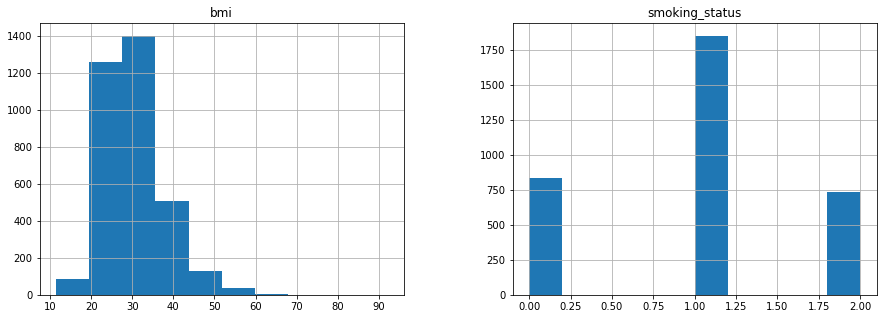

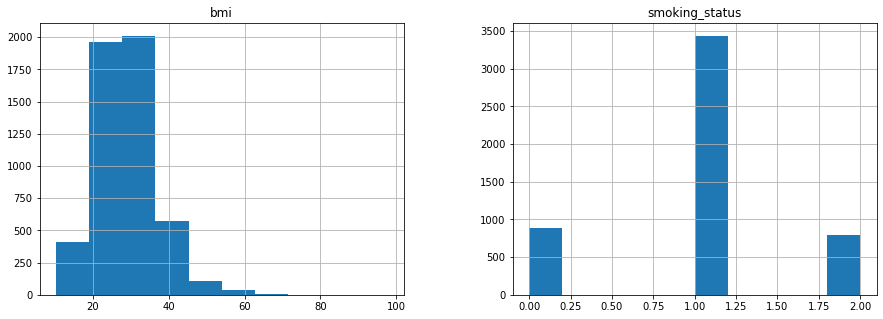

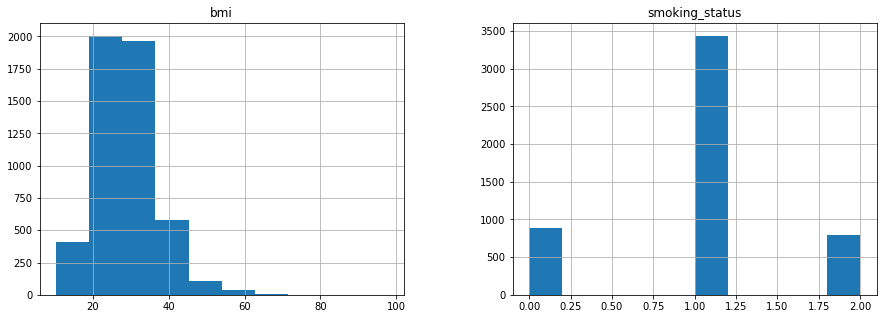

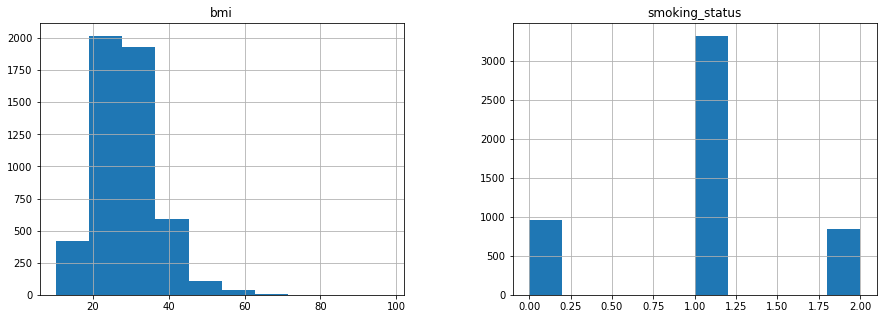

In [47]:
for i in [drop_fill, mean_fill, regression_fill, KNN_fill]:
    i.hist(column = ['bmi', 'smoking_status'], bins=10, figsize=(15,5))

In [95]:
def classification(Data, classifier):
    X = Data.drop(['stroke'], axis=1)
    y = Data['stroke']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)
    
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)
    probs = classifier.predict_proba(X_test)
    print("------------------------------ Classification Results------------------------------")
    target_names = ['Not Stroke','Stroke']
    print(classification_report(y_test, preds,target_names=target_names))
    print(f"""Accuray: {round(accuracy_score(y_test, preds), 5) * 100}%
ROC-AUC: {round(roc_auc_score(y_test, preds), 5) * 100}%\n""")
    print(pd.crosstab(y_test, preds))
    
    fpr, tpr, thresholds = roc_curve(y_test, probs[:,1], pos_label=1, drop_intermediate=False) #roc curve

    fig = plt.figure(figsize=(5,5)) #plot roc curve
    plt.plot(fpr,tpr)
    plt.show()

------------------------------ Classification Results------------------------------
              precision    recall  f1-score   support

  Not Stroke       0.99      0.74      0.85       813
      Stroke       0.15      0.84      0.25        44

    accuracy                           0.74       857
   macro avg       0.57      0.79      0.55       857
weighted avg       0.95      0.74      0.81       857

Accuray: 74.32900000000001%
ROC-AUC: 78.946%

col_0     0    1
stroke          
0       600  213
1         7   37


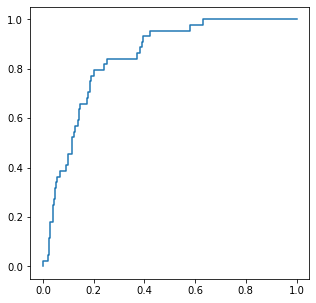

------------------------------ Classification Results------------------------------
              precision    recall  f1-score   support

  Not Stroke       0.99      0.72      0.83      1219
      Stroke       0.12      0.78      0.21        59

    accuracy                           0.72      1278
   macro avg       0.55      0.75      0.52      1278
weighted avg       0.95      0.72      0.80      1278

Accuray: 72.379%
ROC-AUC: 75.03699999999999%

col_0     0    1
stroke          
0       879  340
1        13   46


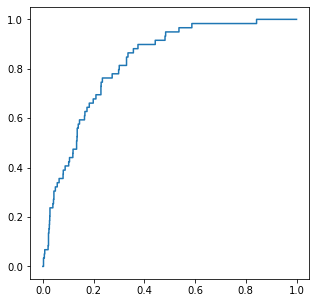

------------------------------ Classification Results------------------------------
              precision    recall  f1-score   support

  Not Stroke       0.99      0.73      0.84      1219
      Stroke       0.12      0.78      0.21        59

    accuracy                           0.73      1278
   macro avg       0.55      0.75      0.52      1278
weighted avg       0.95      0.73      0.81      1278

Accuray: 73.161%
ROC-AUC: 75.447%

col_0     0    1
stroke          
0       889  330
1        13   46


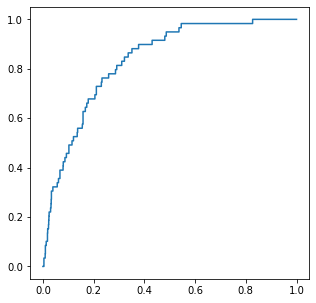

------------------------------ Classification Results------------------------------
              precision    recall  f1-score   support

  Not Stroke       0.99      0.73      0.84      1219
      Stroke       0.12      0.78      0.21        59

    accuracy                           0.73      1278
   macro avg       0.55      0.75      0.52      1278
weighted avg       0.95      0.73      0.81      1278

Accuray: 73.083%
ROC-AUC: 75.40599999999999%

col_0   0.0  1.0
stroke          
0.0     888  331
1.0      13   46


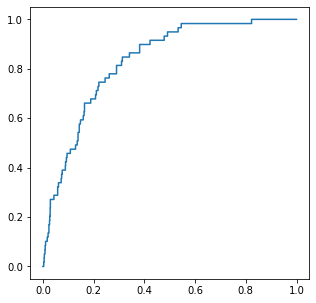

In [102]:
clfMean = RandomForestClassifier(n_estimators=39,max_depth=4,random_state=0, class_weight='balanced')

for i in [drop_fill, mean_fill, regression_fill, KNN_fill]:
    classification(i, clfMean)

In [98]:
train_labels = np.array(encoded_data['stroke'])
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels) # compute the class weights
print(class_wts)

[ 0.52561728 10.25903614]


C:\Users\krist\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


------------------------------ Classification Results------------------------------
              precision    recall  f1-score   support

  Not Stroke       0.98      0.70      0.82       813
      Stroke       0.12      0.75      0.20        44

    accuracy                           0.70       857
   macro avg       0.55      0.72      0.51       857
weighted avg       0.94      0.70      0.78       857

Accuray: 70.128%
ROC-AUC: 72.432%

col_0     0    1
stroke          
0       568  245
1        11   33


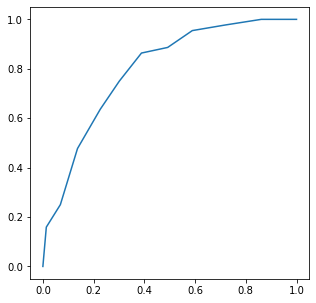

------------------------------ Classification Results------------------------------
              precision    recall  f1-score   support

  Not Stroke       0.98      0.76      0.86      1219
      Stroke       0.12      0.68      0.21        59

    accuracy                           0.76      1278
   macro avg       0.55      0.72      0.53      1278
weighted avg       0.94      0.76      0.83      1278

Accuray: 75.74300000000001%
ROC-AUC: 71.962%

col_0     0    1
stroke          
0       928  291
1        19   40


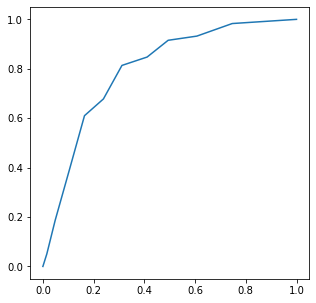

------------------------------ Classification Results------------------------------
              precision    recall  f1-score   support

  Not Stroke       0.98      0.74      0.85      1219
      Stroke       0.12      0.71      0.20        59

    accuracy                           0.74      1278
   macro avg       0.55      0.73      0.53      1278
weighted avg       0.94      0.74      0.82      1278

Accuray: 74.335%
ROC-AUC: 72.83699999999999%

col_0     0    1
stroke          
0       908  311
1        17   42


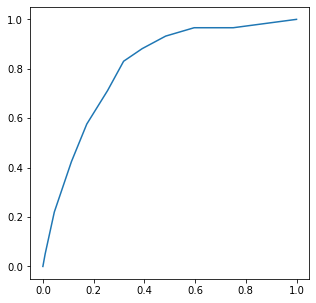

------------------------------ Classification Results------------------------------
              precision    recall  f1-score   support

  Not Stroke       0.98      0.77      0.86      1219
      Stroke       0.13      0.69      0.21        59

    accuracy                           0.76      1278
   macro avg       0.55      0.73      0.54      1278
weighted avg       0.94      0.76      0.83      1278

Accuray: 76.369%
ROC-AUC: 73.097%

col_0   0.0  1.0
stroke          
0.0     935  284
1.0      18   41


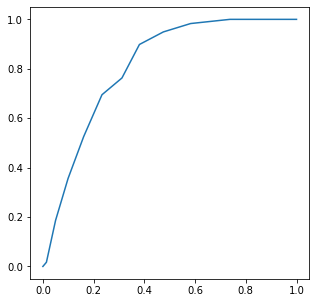

In [106]:
clfMean = BalancedRandomForestClassifier(n_estimators=10)

for i in [drop_fill, mean_fill, regression_fill, KNN_fill]:
    classification(i, clfMean)